### In this example, the distribution of MNIST dataset will be learn and generate new samples form it.

In [1]:
import numpy as np
import optax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from jax.tree_util import tree_map
from torch.utils import data
from functools import partial

from utils.sampling_utils import ula, forward_OU_process, backward_OU_process
from utils.score_matching_utils import sliced_score_matching_loss, weighted_denoising_score_matching_with_ou_process_loss
from model.model import Score_MLP, ScoreNet

### Get the dataset

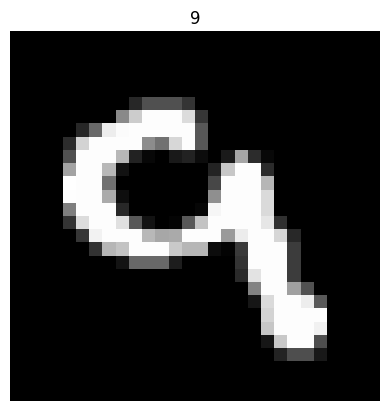

In [2]:
def visual_image(image, label=None):
    plt.figure()
    plt.imshow(image.reshape(28,28),cmap="gray")
    if label:
        plt.title(label)
    plt.axis("off")

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndNormal(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32)) / 255
  
mnist_dataset = MNIST('./dataset', download=True, transform=FlattenAndNormal())
training_dataloader = NumpyLoader(mnist_dataset, batch_size=128, shuffle=True, drop_last=True)

images, labels = next(iter(training_dataloader))
visual_image(images[0], labels[0])
img_dim = images.shape[1]

### Learn the MNIST distribution

In [4]:
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*4, dim=img_dim)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0], 0)
optimizer = optax.adam(learning_rate=1e-3)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(sliced_score_matching_loss, model.apply)

In [4]:
@jax.jit
def params_update(param, optimizer_state, xs, random_key):
    ts = jnp.zeros(xs.shape[0])
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    # get a batch of data
    for i, (images, labels) in enumerate(training_dataloader):
    # one step grad update
        random_key, key_to_use = jax.random.split(random_key)
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, images, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:-3020.11474609375
iter:2, loss:-56349.6953125
iter:3, loss:-313103.5625
iter:4, loss:-947371.1875
iter:5, loss:-1985615.0
iter:6, loss:-3391991.25
iter:7, loss:-5116368.0
iter:8, loss:-7439442.5
iter:9, loss:-11705952.0
iter:10, loss:-11761086.0
iter:11, loss:-19942118.0
iter:12, loss:-22752380.0
iter:13, loss:-29837240.0
iter:14, loss:-36100944.0
iter:15, loss:-39047772.0
iter:16, loss:-49042764.0
iter:17, loss:-55367636.0
iter:18, loss:-64736764.0
iter:19, loss:-71657608.0
iter:20, loss:-87616336.0
iter:21, loss:-73667448.0
iter:22, loss:-89608296.0
iter:23, loss:-82057136.0
iter:24, loss:-112586600.0
iter:25, loss:-133362488.0
iter:26, loss:-144617648.0
iter:27, loss:-163042608.0
iter:28, loss:-119566000.0
iter:29, loss:-122691928.0
iter:30, loss:-128915120.0
iter:31, loss:-126821872.0
iter:32, loss:-151021328.0
iter:33, loss:-174050832.0
iter:34, loss:-189070944.0
iter:35, loss:-286356992.0
iter:36, loss:-312767872.0
iter:37, loss:-337938976.0
iter:38, loss:-350249504.

[]

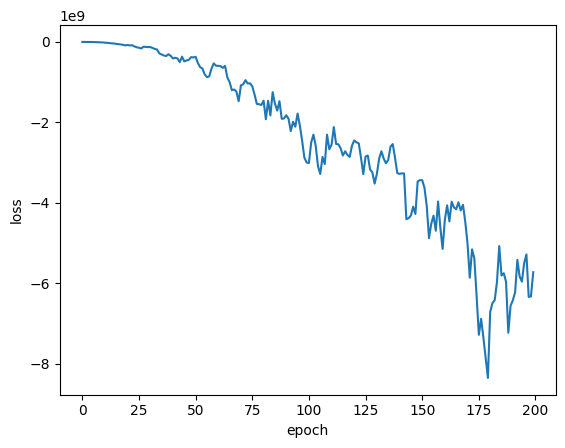

In [5]:
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

### Evaluate numerical stability
The score-matching loss tend to be very big numerically.
Here we try to evaluate the numerical value of **(model param) gradient**,and the **score value** in and out of distributions   

Here, we see simply run score-matching and Langevin dynamics lead to a very **big numerical value** for score even inside distribition. Moreover, after one-step Langevin dynamics, the update result is not a valid image anymore and the score function there is **very very big**, further drift the sample away.

We also going to estimate the Lipschitz constant L of the learned function. Theoretically, for a alpha-LSI target distribution, we should choose the step size for ULA to be smaller than alpha / 4L**2. Note the alpha here can also be very large

In [6]:
# Numerical stability
loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(model_param, images, np.zeros(images.shape[0]), random_key)

for layer in grad["params"]:

    kernel_max = jnp.max(jnp.abs(grad["params"][layer]["kernel"]))
    bias_max = jnp.max(jnp.abs(grad["params"][layer]["bias"]))
    print(f"Layer:{layer}, Kernel max:{kernel_max}, Bias max:{bias_max}")

print(f"Max score inside dist:{jnp.max(jnp.abs(model.apply(model_param, images[0], 0)))}")
images_after_one_step_LD = model.apply(model_param, images[0], 0) * 0.01 + images[0]
print(f"Image max-min after one step Langevin dynamics {np.max(images_after_one_step_LD)}, {np.min(images_after_one_step_LD)}" )
print(f"Max score out dist(use one step update image):{jnp.max(jnp.abs(model.apply(model_param, images_after_one_step_LD, 0)))}")

@jax.jit
def learned_score_function_smooth_anaysis(x, y):
    return jnp.linalg.norm(model.apply(model_param, x, 0) - model.apply(model_param, y, 0)) - jnp.linalg.norm(x-y)

L = 0
for i in range(100):
    random_two_image = images[np.random.choice(images.shape[0],size=2),:]
    L_candidate = learned_score_function_smooth_anaysis(random_two_image[0], random_two_image[1])
    if L < L_candidate:
        L = L_candidate

print("Estimate L-smooth of learned score is:", L)

Layer:Dense_0, Kernel max:7967108608.0, Bias max:7789320192.0
Layer:Dense_1, Kernel max:2824254208.0, Bias max:994589760.0
Layer:Dense_2, Kernel max:454331072.0, Bias max:79873552.0
Layer:Dense_3, Kernel max:292470976.0, Bias max:4350045.0
Layer:Dense_4, Kernel max:6749514.0, Bias max:5792.669921875
Max score inside dist:6798.5322265625
Image max-min after one step Langevin dynamics 67.41815948486328, -67.98532104492188
Max score out dist(use one step update image):68104806400.0
Estimate L-smooth of learned score is: 169829.25


Neural network prefer to learn function that do not have quick change in the magnitude. 

If function we try to approximate is nonsmooth, i.e. function value change dramatically as the input change slightly, the numerical value of neural network weight will also be pretty big, cause instability and gradient explore up in practice.

Previously, we see learn score function for the original function can be quite nonsmooth in x. Here, we also want to evaluate how the norm of score function envolve along OU process, which will be used in the diffusion process.


Suppose we learn the score function of origin image $s_\theta(x, 0)$, then along OU process, the distribution will close to standard Gaussian, with the score roughly $s(x, 0) \approx -x$.
Seems for this problem, when $t = 5$, the distribution is alreay close to standard Gaussian.
So we can random draw a image x, compute its learned norm of learn score at time zero, and estimate the score at time=1 with same image as $\|x\|$

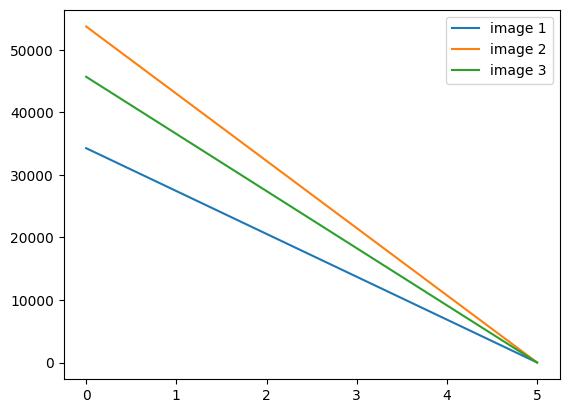

In [7]:
image_0 = images[0]
image_1 = images[1]
image_2 = images[2]
plt.figure()
plt.plot([0,5], [np.linalg.norm(model.apply(model_param, image_0, 0)), np.linalg.norm(image_0)], label="image 1")
plt.plot([0,5], [np.linalg.norm(model.apply(model_param, image_1, 0)), np.linalg.norm(image_1)], label="image 2")
plt.plot([0,5], [np.linalg.norm(model.apply(model_param, image_2, 0)), np.linalg.norm(image_2)], label="image 3")
plt.legend()
plt.show()

### Generate sample use learned score function

The initial score function biggest entries 33431.77


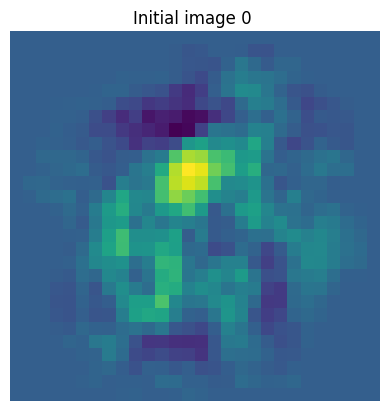

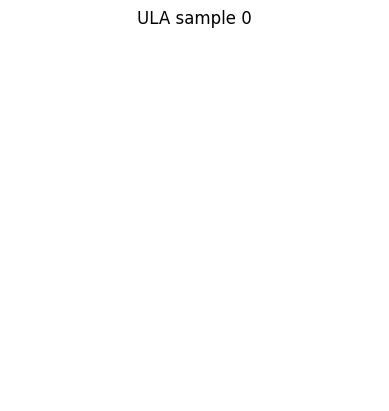

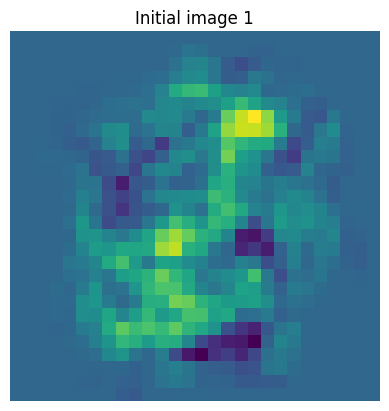

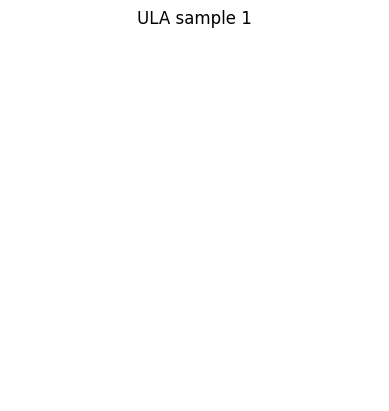

In [8]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, jnp.zeros_like(t))

random_key = jax.random.PRNGKey(0)

# use mean and cov calculate from samples to construct a Gaussian
x0s = np.random.multivariate_normal(mean=np.mean(images,axis=0), cov=np.cov(images, rowvar=False), size=2)
random_keys = jax.random.split(random_key, 2)

ula_wrapped = partial(ula, learned_score_fn, T=1, dt=0.01)

samples = jax.vmap(ula_wrapped)(x0s, random_keys)

print("The initial score function biggest entries", np.max(np.abs(learned_score_fn(x0s, np.array([0,0])))))

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="ULA sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="ULA sample 1")

### Train diffusion model on MNIST

In [9]:
random_key = jax.random.PRNGKey(0)
model = Score_MLP(features=[128]*5, dim=img_dim)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0], 0)
optimizer = optax.adam(learning_rate=1e-4)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(sliced_score_matching_loss, model.apply)
forward_OU_process_vmap = jax.jit(jax.vmap(forward_OU_process))

# Time for forward OU process to run
T = 5
T_min = 0.01

@jax.jit
def params_update(param, optimizer_state, xs, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    for i, (images, labels) in enumerate(training_dataloader):
        # get a batch of data
        ts = np.random.uniform(T_min, T, size=images.shape[0])
        random_key, key_to_use = jax.random.split(random_key)
        keys_to_use = jax.random.split(key_to_use, images.shape[0])
        noisy_images = forward_OU_process_vmap(images, ts, keys_to_use)
        # one step grad update
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, noisy_images, ts, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:20.650798797607422
iter:2, loss:-4.640540599822998
iter:3, loss:-12.658159255981445
iter:4, loss:-17.869583129882812
iter:5, loss:-21.53911781311035
iter:6, loss:-24.43452262878418
iter:7, loss:-26.911298751831055
iter:8, loss:-29.01998519897461
iter:9, loss:-30.669546127319336
iter:10, loss:-32.15492248535156
iter:11, loss:-33.28719711303711
iter:12, loss:-34.47698211669922
iter:13, loss:-35.35026550292969
iter:14, loss:-36.2208366394043
iter:15, loss:-37.05248260498047
iter:16, loss:-37.71306610107422
iter:17, loss:-38.6547966003418
iter:18, loss:-39.136173248291016
iter:19, loss:-39.65653610229492
iter:20, loss:-40.515655517578125
iter:21, loss:-41.10224151611328
iter:22, loss:-41.831153869628906
iter:23, loss:-42.13187789916992
iter:24, loss:-42.96054458618164
iter:25, loss:-43.40966033935547
iter:26, loss:-43.759395599365234
iter:27, loss:-44.207672119140625
iter:28, loss:-44.601402282714844
iter:29, loss:-44.94828796386719
iter:30, loss:-45.392948150634766
iter:31, l

[]

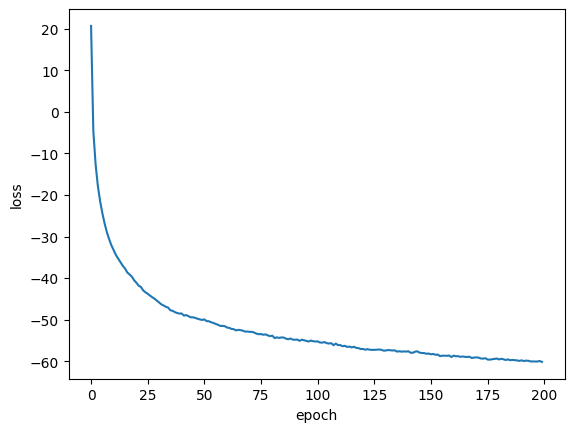

In [10]:
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

### Visualize the image from forward OU process

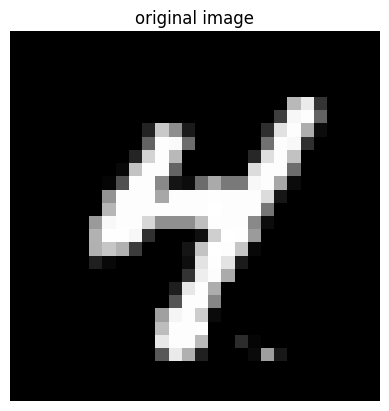

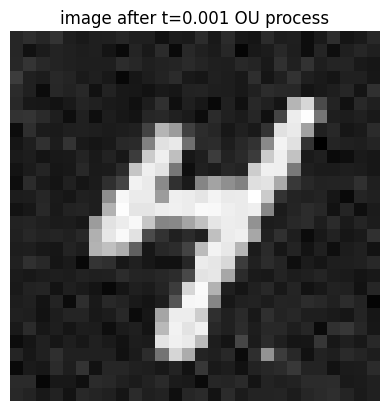

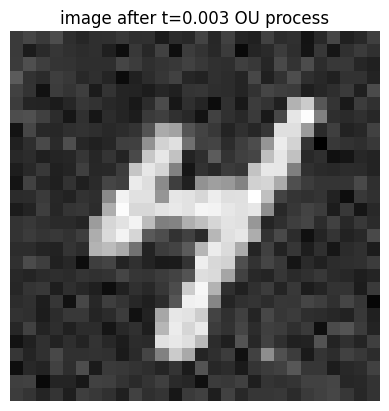

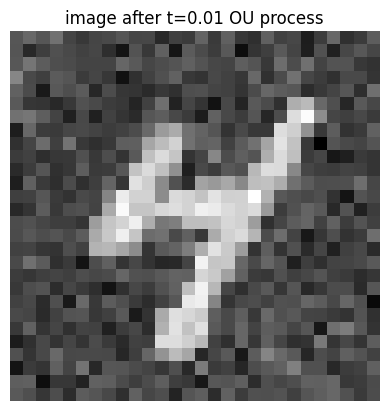

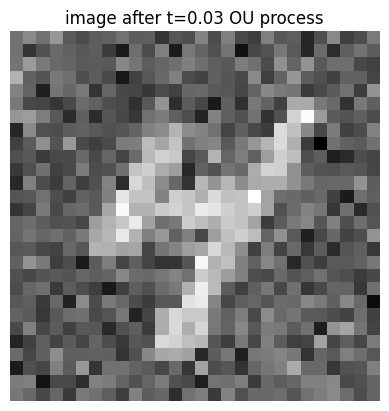

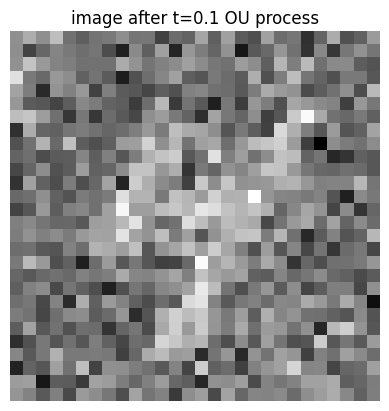

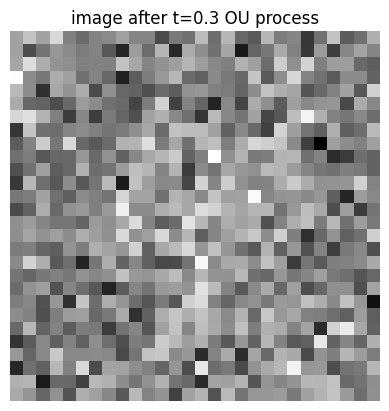

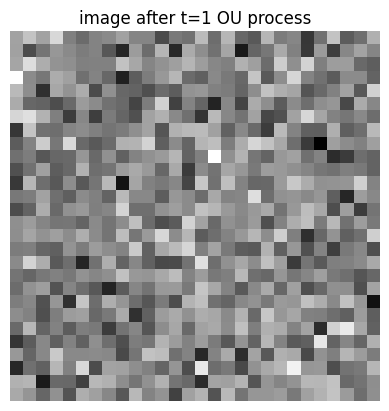

In [8]:
image = images[0]
visual_image(image, "original image")
noisy_image_0001 = forward_OU_process(image, 0.001, random_key)
visual_image(noisy_image_0001, "image after t=0.001 OU process")
noisy_image_0003 = forward_OU_process(image, 0.003, random_key)
visual_image(noisy_image_0003, "image after t=0.003 OU process")
noisy_image_001 = forward_OU_process(image, 0.01, random_key)
visual_image(noisy_image_001, "image after t=0.01 OU process")
noisy_image_003 = forward_OU_process(image, 0.03, random_key)
visual_image(noisy_image_003, "image after t=0.03 OU process")
noisy_image_01 = forward_OU_process(image, 0.1, random_key)
visual_image(noisy_image_01, "image after t=0.1 OU process")
noisy_image_03 = forward_OU_process(image, 0.3, random_key)
visual_image(noisy_image_03, "image after t=0.3 OU process")
noisy_image_1 = forward_OU_process(image, 1, random_key)
visual_image(noisy_image_1, "image after t=1 OU process")


### Sample from diffusion model on MNIST

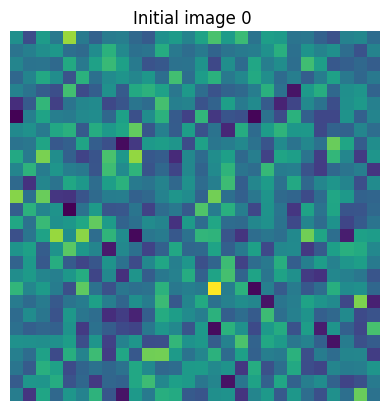

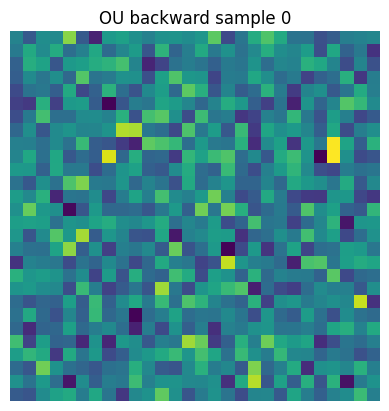

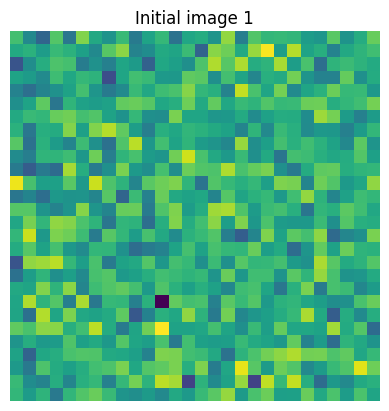

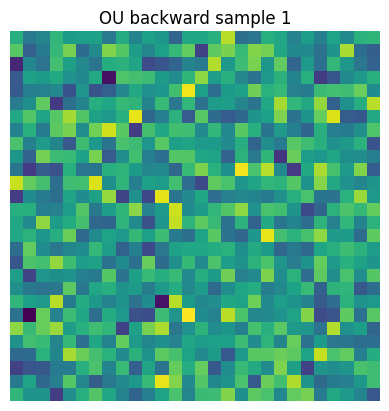

In [12]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, t)

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(img_dim), cov=np.eye(img_dim), size=2)
random_keys = jax.random.split(random_key, 2)

backward_OU_process_wrapped = partial(backward_OU_process, learned_score_fn, T=T, dt=1e-3, t0=T_min)

samples = jax.vmap(backward_OU_process_wrapped)(x0s, random_keys)

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="OU backward sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="OU backward sample 1")


Try to get sense what's the magnitude of Fisher information, when we apply t=0.01 OU process 

In [13]:
model_param_ou_001 = model.init(key_to_use, images[0], 0)
optimizer_ou_001 = optax.adam(learning_rate=1e-4)
optimizer_state_001 = optimizer_ou_001.init(model_param)

@jax.jit
def params_update_ou001(param, optimizer_state, xs, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer_ou_001.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    for i, (images, labels) in enumerate(training_dataloader):
        # get a batch of data
        ts = np.ones(images.shape[0]) * 0.01
        random_key, key_to_use = jax.random.split(random_key)
        keys_to_use = jax.random.split(key_to_use, images.shape[0])
        noisy_images = forward_OU_process_vmap(images, ts, keys_to_use)
        # one step grad update
        loss, model_param_ou_001, optimizer_state_001 = params_update_ou001(model_param_ou_001, optimizer_state_001, noisy_images, ts, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:15.88806438446045
iter:2, loss:-151.7149200439453
iter:3, loss:-282.54766845703125
iter:4, loss:-361.4241027832031
iter:5, loss:-420.5015869140625
iter:6, loss:-466.0863342285156
iter:7, loss:-509.5638122558594
iter:8, loss:-544.4273071289062
iter:9, loss:-579.78515625
iter:10, loss:-607.1759033203125
iter:11, loss:-639.0670166015625
iter:12, loss:-662.7910766601562
iter:13, loss:-689.76220703125
iter:14, loss:-713.68017578125
iter:15, loss:-735.37939453125
iter:16, loss:-760.3302612304688
iter:17, loss:-780.1290893554688
iter:18, loss:-803.3384399414062
iter:19, loss:-825.1665649414062
iter:20, loss:-847.4306640625
iter:21, loss:-872.2924194335938
iter:22, loss:-890.8850708007812
iter:23, loss:-912.8285522460938
iter:24, loss:-929.7086181640625
iter:25, loss:-947.2888793945312
iter:26, loss:-965.15771484375
iter:27, loss:-986.08203125
iter:28, loss:-996.1355590820312
iter:29, loss:-1013.6536865234375
iter:30, loss:-1025.06005859375
iter:31, loss:-1046.752197265625
iter:32

[]

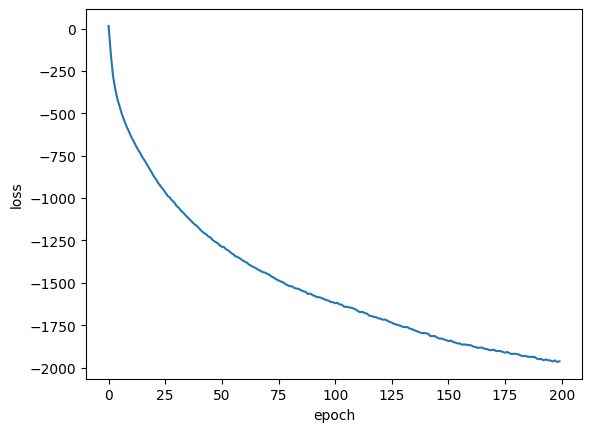

In [14]:
@jax.jit
def learned_score_fn_ou001(x):
    return model.apply(model_param_ou_001, x, 0.01)
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

Similar to previous, here we test how nonsmooth of $\rho_t$ in the t direction

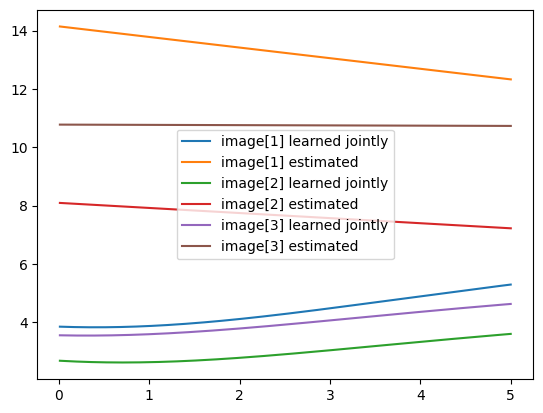

In [15]:
ts = np.arange(T_min, T, 1e-3)
plt.figure()
test_image = np.copy(images[:3])
score_norms_list = []
for (i, image) in enumerate(test_image):
    score_norms = []
    for t in ts:
        score_norms.append(np.linalg.norm(learned_score_fn(image, t)))
    score_norms_list = []
    plt.plot(ts, score_norms, label=f"image[{i+1}] learned jointly")
    plt.plot([0.01, 5], [np.linalg.norm(learned_score_fn_ou001(image)), np.linalg.norm(image)], label=f"image[{i+1}] estimated")
plt.legend()
plt.show()

### Train diffusion model with weighted denoising score matching objective

We see the original score can have very different scale based on t (or really $\rho_t$), and the output of neural network can be very large.

Here, we apply normalized denoisy score matching objective to solve this issue.

The paper can be quite good reference
    https://arxiv.org/pdf/2209.11215


In [5]:
random_key = jax.random.PRNGKey(0)

# Note here the neural model output \sqrt{1-\exp{(-2t)}} s_t(X_t) instead of the score
model = Score_MLP(features=[128]*5, dim=img_dim)
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0], 0)
optimizer = optax.adam(learning_rate=1e-4)
optimizer_state = optimizer.init(model_param)

score_matching_loss_wrapped = partial(weighted_denoising_score_matching_with_ou_process_loss, model.apply)

# Time for forward OU process to run
T = 5
T_min = 0

@jax.jit
def params_update(param, optimizer_state, x0s, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, x0s, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(200):
    total_loss = 0
    for i, (images, labels) in enumerate(training_dataloader):
        ts = np.random.uniform(T_min, T, size=images.shape[0])
        random_key, key_to_use = jax.random.split(random_key)
        # one step grad update
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, images, ts, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:825.7833862304688
iter:2, loss:777.0380249023438
iter:3, loss:760.9740600585938
iter:4, loss:746.712646484375
iter:5, loss:736.8850708007812
iter:6, loss:729.8867797851562
iter:7, loss:724.3709106445312
iter:8, loss:719.8082885742188
iter:9, loss:715.9019165039062
iter:10, loss:712.66943359375
iter:11, loss:709.9812622070312
iter:12, loss:707.8145141601562
iter:13, loss:706.028076171875
iter:14, loss:704.403076171875
iter:15, loss:702.974853515625
iter:16, loss:701.86376953125
iter:17, loss:700.4866333007812
iter:18, loss:699.8229370117188
iter:19, loss:698.9061889648438
iter:20, loss:698.0388793945312
iter:21, loss:697.2107543945312
iter:22, loss:696.4819946289062
iter:23, loss:695.8508911132812
iter:24, loss:695.1712036132812
iter:25, loss:694.4983520507812
iter:26, loss:693.6895141601562
iter:27, loss:693.259033203125
iter:28, loss:692.605712890625
iter:29, loss:692.5833129882812
iter:30, loss:691.7206420898438
iter:31, loss:691.6267700195312
iter:32, loss:691.183776855

[]

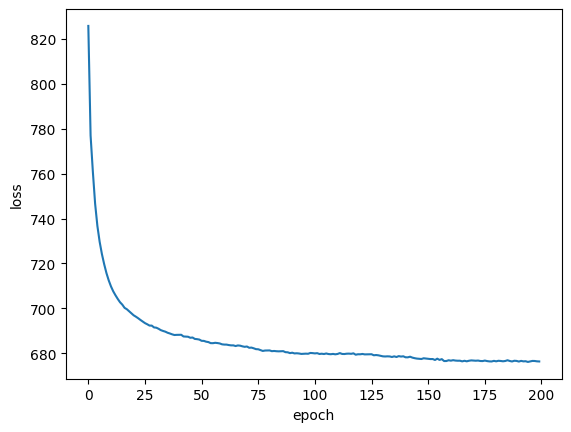

In [17]:
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

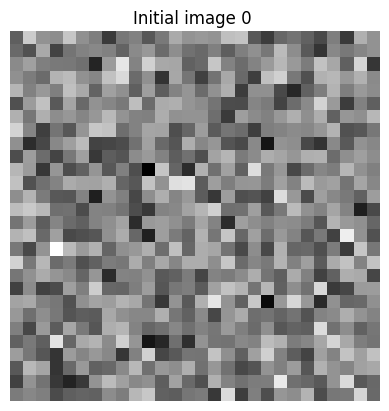

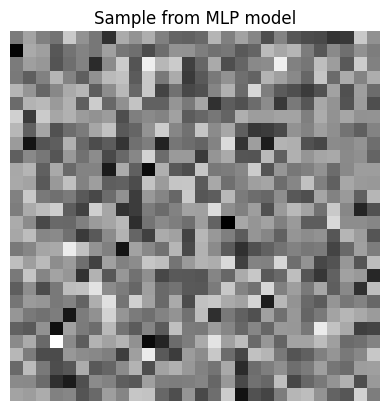

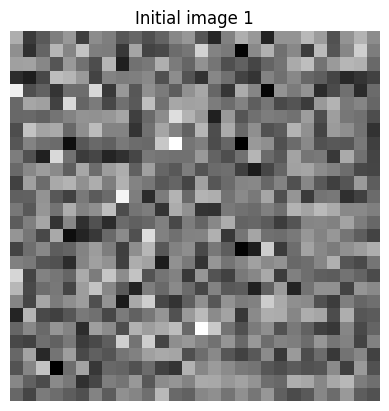

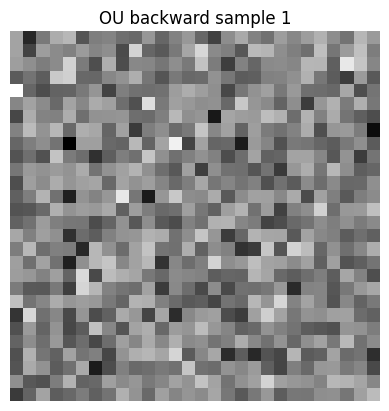

In [8]:
@jax.jit
def learned_score_fn(x, t):
    return model.apply(model_param, x, t) / (1-jnp.exp(-2*t))**0.5

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(img_dim), cov=np.eye(img_dim), size=2)
random_keys = jax.random.split(random_key, 2)

backward_OU_process_wrapped = partial(backward_OU_process, learned_score_fn, T=T, dt=1e-3, t0=T_min)

samples = jax.vmap(backward_OU_process_wrapped)(x0s, random_keys)

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="OU backward sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="OU backward sample 1")

### Training with unet architecture

In [9]:
random_key = jax.random.PRNGKey(0)

# Note here the neural model output \sqrt{1-\exp{(-2t)}} s_t(X_t) instead of the score
model = ScoreNet()
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0].reshape(1,28,28,1), jnp.zeros(1,))
optimizer = optax.adam(learning_rate=1e-4)
optimizer_state = optimizer.init(model_param)

def wrapped_model_apply(params, xs, ts):
    xs = xs.reshape(-1, 28, 28, 1)
    output = model.apply(params, xs, ts)
    return output.reshape(-1, 28*28)

score_matching_loss_wrapped = partial(weighted_denoising_score_matching_with_ou_process_loss, wrapped_model_apply)

# Time for forward OU process to run
T = 5
T_min = 0

@jax.jit
def params_update(param, optimizer_state, x0s, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, x0s, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(20):
    total_loss = 0
    for i, (images, labels) in enumerate(training_dataloader):
        ts = np.random.uniform(T_min, T, size=images.shape[0])
        random_key, key_to_use = jax.random.split(random_key)
        # one step grad update
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, images, ts, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:145.91192626953125
iter:2, loss:53.294891357421875
iter:3, loss:34.01551818847656
iter:4, loss:24.756732940673828
iter:5, loss:19.761526107788086
iter:6, loss:17.098466873168945
iter:7, loss:14.91116714477539
iter:8, loss:13.27723217010498
iter:9, loss:12.289534568786621
iter:10, loss:11.207005500793457
iter:11, loss:10.667451858520508
iter:12, loss:10.105587005615234
iter:13, loss:9.444038391113281
iter:14, loss:8.970772743225098
iter:15, loss:8.851676940917969
iter:16, loss:8.712173461914062
iter:17, loss:8.309882164001465
iter:18, loss:8.313148498535156
iter:19, loss:8.173276901245117
iter:20, loss:8.089029312133789


In [ ]:
plt.figure()
plt.plot(losses, label="training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()

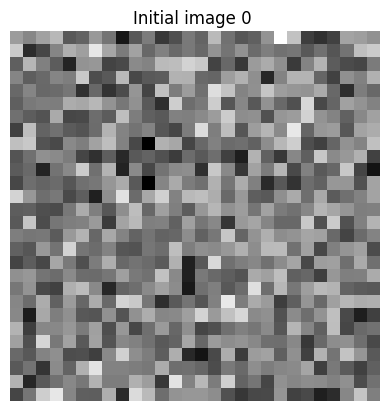

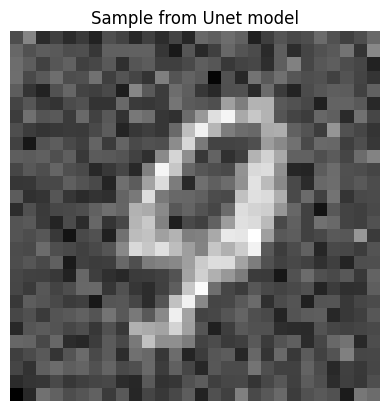

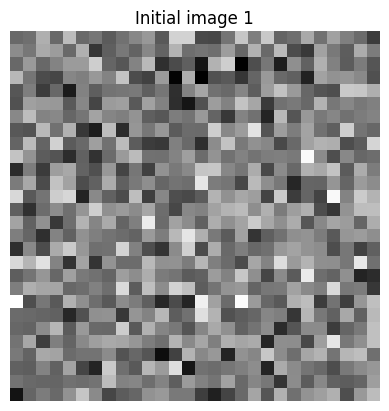

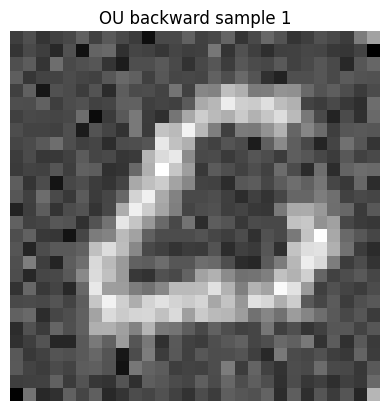

In [21]:
@jax.jit
def learned_score_fn(x, t):
    return wrapped_model_apply(model_param, x, t) / (1-jnp.exp(-2*t))**0.5

random_key = jax.random.PRNGKey(1)
x0s = np.random.multivariate_normal(mean=np.zeros(img_dim), cov=np.eye(img_dim), size=2)
random_keys = jax.random.split(random_key, 2)

backward_OU_process_wrapped = partial(backward_OU_process, learned_score_fn, T=3, dt=1e-2, t0=0.01)

samples = jax.vmap(backward_OU_process_wrapped)(x0s, random_keys)

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="OU backward sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="OU backward sample 1")

In [3]:
random_key = jax.random.PRNGKey(0)
model = ScoreNet()
random_key, key_to_use = jax.random.split(random_key)
model_param = model.init(key_to_use, images[0].reshape(1,28,28,1), jnp.zeros(1,))
optimizer = optax.adam(learning_rate=1e-4)
optimizer_state = optimizer.init(model_param)

def wrapped_model_apply(params, xs, ts):
    xs = xs.reshape(-1, 28, 28, 1)
    output = model.apply(params, xs, ts)
    return output.reshape(28*28)

score_matching_loss_wrapped = partial(sliced_score_matching_loss, wrapped_model_apply)
forward_OU_process_vmap = jax.jit(jax.vmap(forward_OU_process))

# Time for forward OU process to run
T = 5
T_min = 0

@jax.jit
def params_update(param, optimizer_state, xs, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

losses = []
for epoch in range(20):
    total_loss = 0
    for i, (images, labels) in enumerate(training_dataloader):
        # get a batch of data
        ts = np.random.uniform(T_min, T, size=images.shape[0])
        random_key, key_to_use = jax.random.split(random_key)
        keys_to_use = jax.random.split(key_to_use, images.shape[0])
        noisy_images = forward_OU_process_vmap(images, ts, keys_to_use)
        # one step grad update
        loss, model_param, optimizer_state = params_update(model_param, optimizer_state, noisy_images, ts, key_to_use)
        total_loss += loss
    
    losses.append(total_loss / len(training_dataloader))
    print(f"iter:{epoch+1}, loss:{losses[-1]}")

iter:1, loss:-390.22955322265625
iter:2, loss:-477.435791015625
iter:3, loss:-515.8424682617188
iter:4, loss:-541.6036376953125
iter:5, loss:-548.4967041015625
iter:6, loss:-563.2140502929688
iter:7, loss:-556.4240112304688
iter:8, loss:-581.3726196289062
iter:9, loss:-562.746826171875
iter:10, loss:-568.34619140625
iter:11, loss:-584.267333984375
iter:12, loss:-584.822021484375
iter:13, loss:-586.89599609375
iter:14, loss:-596.4632568359375
iter:15, loss:-592.2965087890625
iter:16, loss:-599.2342529296875
iter:17, loss:-582.8515625
iter:18, loss:-597.446533203125
iter:19, loss:-612.0249633789062
iter:20, loss:-610.365234375


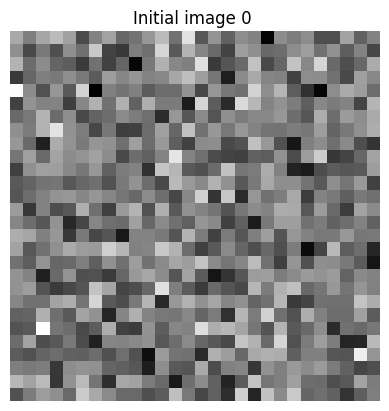

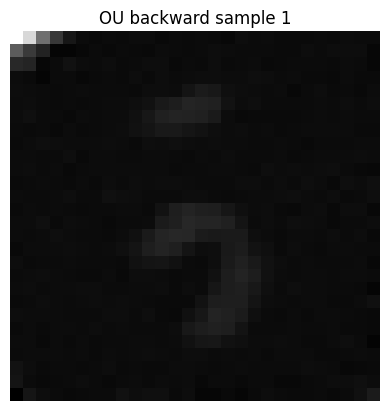

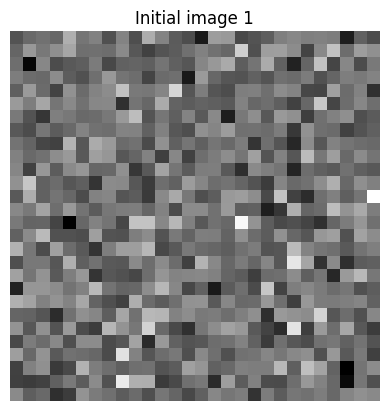

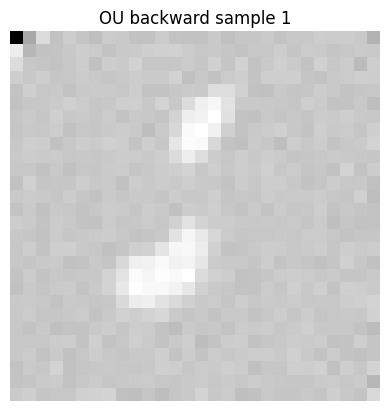

In [7]:
@jax.jit
def learned_score_fn(x, t):
    # the output of neural network under sliced score matching objective should directly be the score function, 
    # however we find we still need to scale the output by (1-jnp.exp(-2*t))**0.5 to obtain reasonable images
    return wrapped_model_apply(model_param, x, t) / (1-jnp.exp(-2*t))**0.5

random_key = jax.random.PRNGKey(0)
x0s = np.random.multivariate_normal(mean=np.zeros(img_dim), cov=np.eye(img_dim), size=2)
random_keys = jax.random.split(random_key, 2)

backward_OU_process_wrapped = partial(backward_OU_process, learned_score_fn, T=T, dt=1e-3, t0=0.01)

samples = jax.vmap(backward_OU_process_wrapped)(x0s, random_keys)

visual_image(x0s[0], label="Initial image 0 ")
visual_image(samples[0], label="OU backward sample 0")
visual_image(x0s[1], label="Initial image 1")
visual_image(samples[1], label="OU backward sample 1")

### Investigate the smoothness of data distribution

In [11]:
forward_OU_ts = [0, 0.001, 0.01, 0.1, 1, 10]

@jax.jit
def params_update(param, optimizer_state, xs, ts, random_key):
    loss, grad = jax.value_and_grad(score_matching_loss_wrapped)(param, xs, ts, random_key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, param)
    param = optax.apply_updates(param, update)
    return loss, param, optimizer_state

def wrapped_model_apply(params, xs, ts):
    xs = xs.reshape(-1, 28, 28, 1)
    output = model.apply(params, xs, ts)
    return output.reshape(28*28)

score_matching_loss_wrapped = partial(sliced_score_matching_loss, wrapped_model_apply)
forward_OU_process_vmap = jax.jit(jax.vmap(forward_OU_process))

losses_among_different_forward_OU_process_t = []
for forward_OU_t in forward_OU_ts:

    losses = []
    
    random_key = jax.random.PRNGKey(0)
    model = ScoreNet()
    random_key, key_to_use = jax.random.split(random_key)
    model_param = model.init(key_to_use, images[0].reshape(1,28,28,1), jnp.zeros(1,))
    optimizer = optax.adam(learning_rate=1e-4)
    optimizer_state = optimizer.init(model_param)
    
    for epoch in range(20):
        total_loss = 0
        for i, (images, labels) in enumerate(training_dataloader):
            # get a batch of data
            ts = np.ones(images.shape[0]) * forward_OU_t
            random_key, key_to_use = jax.random.split(random_key)
            keys_to_use = jax.random.split(key_to_use, images.shape[0])
            noisy_images = forward_OU_process_vmap(images, ts, keys_to_use)
            # one step grad update
            loss, model_param, optimizer_state = params_update(model_param, optimizer_state, noisy_images, ts, key_to_use)
            total_loss += loss
        
        losses.append(total_loss / len(training_dataloader))
        print(f"t:{forward_OU_t}, iter:{epoch+1}, loss:{losses[-1]}")

    losses_among_different_forward_OU_process_t.append(losses)


t:0, iter:1, loss:-276952.90625
t:0, iter:2, loss:-2274941.0
t:0, iter:3, loss:-8155615.0
t:0, iter:4, loss:-20950942.0
t:0, iter:5, loss:-43932412.0
t:0, iter:6, loss:-76944888.0
t:0, iter:7, loss:-128620912.0
t:0, iter:8, loss:-170699888.0
t:0, iter:9, loss:-270367456.0
t:0, iter:10, loss:-350034176.0
t:0, iter:11, loss:-479479360.0
t:0, iter:12, loss:-646118976.0
t:0, iter:13, loss:-788617600.0
t:0, iter:14, loss:-964832384.0
t:0, iter:15, loss:-1230022784.0
t:0, iter:16, loss:-1481599744.0
t:0, iter:17, loss:-1502795904.0
t:0, iter:18, loss:-1735782272.0
t:0, iter:19, loss:-2512672256.0
t:0, iter:20, loss:-2449936896.0
t:0.001, iter:1, loss:-32074.685546875
t:0.001, iter:2, loss:-72162.90625
t:0.001, iter:3, loss:-97172.3984375
t:0.001, iter:4, loss:-114278.28125
t:0.001, iter:5, loss:-126383.3125
t:0.001, iter:6, loss:-134631.671875
t:0.001, iter:7, loss:-140229.296875
t:0.001, iter:8, loss:-143857.640625
t:0.001, iter:9, loss:-146195.375
t:0.001, iter:10, loss:-148090.359375
t:0.

### Visial fisher information bounds

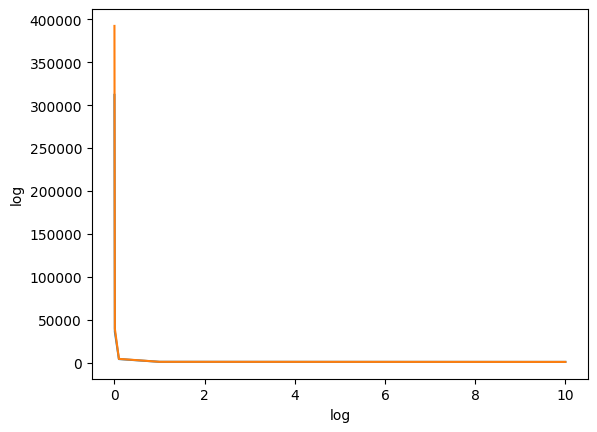

In [24]:
fisher_lower_bounds = []
for losses in losses_among_different_forward_OU_process_t:
    fisher_lower_bounds.append(-2 * min(losses))

fisher_upper_bounds = []
for forward_OU_t in forward_OU_ts:
    fisher_upper_bounds.append(28 * 28 / (1-jnp.exp(-2 * forward_OU_t) + 1e-10))

plt.figure()
plt.plot(forward_OU_ts[1:], fisher_lower_bounds[1:], label="fisher lower bounds")
plt.plot(forward_OU_ts[1:], fisher_upper_bounds[1:], label="fisher upper bound")
plt.yscale("log")
plt.xlabel("log")
plt.show()